# Leaf Disease Classification

## Potato Leaf Disease classification Model Training

### Import all the Dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

### Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3  # denotes the number of color channels in the image
EPOCHS=30  # Best epoch 25 

### Reading and Generating the Train, Test and Validation data using ImageDataGenerator

##### We will use ImageDataGenerator api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory('DataSets/Potato/train', 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                    batch_size=32,
                                                    class_mode="sparse")
   

Found 1506 images belonging to 3 classes.


In [5]:
validation_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory('DataSets/Potato/val', 
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                               batch_size=32,
                                                               class_mode="sparse")

Found 322 images belonging to 3 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True)
test_generator = test_datagen.flow_from_directory('DataSets/Potato/test', 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode="sparse")

Found 324 images belonging to 3 classes.


### Knowing the DataStructure

In [6]:
total_samples = train_generator.n
batch_size = train_generator.batch_size

print(f'The train_generator consists {total_samples} image data with their labels.' )
print(f'The {total_samples} images are stored in batches of size {batch_size}.')

# Calculate the number of batches
num_batches_train = total_samples // batch_size

# If there are remaining samples that don't complete a full batch, add one more batch
if total_samples % batch_size != 0:
    num_batches_train += 1

print("Total number of batches in train_generator:", num_batches_train)

The train_generator consists 1506 image data with their labels.
The 1506 images are stored in batches of size 32.
Total number of batches in train_generator: 48


In [7]:
# Lets Load a batch and explore it
batch = train_generator.next()
print(f'The batch consists of {len(batch)} elements a images_batch and a labels_batch of 32 samples max:' )
print('-'*108)
print('The batch size is 32 and image shape is 256*256 in rbg format(3):\n', batch[0].shape)
print()
print('The labels of 32 images in a batch are :\n', batch[1])

The batch consists of 2 elements a images_batch and a labels_batch of 32 samples max:
------------------------------------------------------------------------------------------------------------
The batch size is 32 and image shape is 256*256 in rbg format(3):
 (32, 256, 256, 3)

The labels of 32 images in a batch are :
 [2. 1. 1. 1. 0. 1. 0. 1. 1. 2. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 2.
 0. 0. 1. 0. 0. 1. 1. 2.]


In [8]:
classes = list(train_generator.class_indices.keys())
print(f'Number of classes {len(classes)}')
print(classes)

Number of classes 3
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [7]:
class_names = ['Potato Early blight', 'Potato Late_blight', 'Potato healthy']

(-0.5, 255.5, 255.5, -0.5)

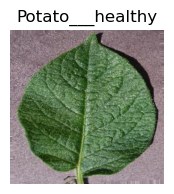

In [10]:
images_batch, labels_batch = batch
image1 = images_batch[0]
label1 = labels_batch[0]

plt.figure(figsize=(2, 2))
plt.imshow(image1)
plt.title(classes[int(label1)])
plt.axis('off') 

## Building the Model

### Model Architecture
1. We use a CNN coupled with a `softmax` activation in the output layer. 
2. Use `train_generator`, `validation_generator` to resize and scale data; and also generate augmented data

In [11]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),  # Adding dropout with a rate (adjust rate as needed)
    layers.Dense(n_classes, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

* Use `SparseCategoricalCrossentropy` when your target labels are integers (class indices).
* Use `CategoricalCrossentropy` when your target labels are one-hot encoded vectors.

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [13]:
# steps_per_epoch = total_samples / batch_size 
num_batches_train  # we already calculated above

48

In [14]:
# For validation_steps  (total_samples / batch_size)

num_batches_val = validation_generator.n // validation_generator.batch_size
if total_samples % batch_size != 0: # If there are remaining samples that don't complete a full batch, add one more batch
    num_batches_val += 1
    
num_batches_val

11

In [15]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)


# Convert to a dictionary to be used in model.fit
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.7171428571428572, 1: 0.7171428571428572, 2: 4.735849056603773}

In [16]:
# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=48,  # num_batches_train
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=11,  # num_batches_val
    verbose=1,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

Epoch 1/30
48/48 [==============================] - 84s 2s/step - loss: 1.0923 - accuracy: 0.4210 - val_loss: 0.9358 - val_accuracy: 0.4627
Epoch 2/30
48/48 [==============================] - 97s 2s/step - loss: 0.8571 - accuracy: 0.5445 - val_loss: 0.7091 - val_accuracy: 0.6180
Epoch 3/30
48/48 [==============================] - 100s 2s/step - loss: 0.6566 - accuracy: 0.6235 - val_loss: 1.0002 - val_accuracy: 0.5124
Epoch 4/30
48/48 [==============================] - 90s 2s/step - loss: 0.6421 - accuracy: 0.6567 - val_loss: 0.4380 - val_accuracy: 0.8199
Epoch 5/30
48/48 [==============================] - 97s 2s/step - loss: 0.5072 - accuracy: 0.7218 - val_loss: 0.5534 - val_accuracy: 0.7516
Epoch 6/30
48/48 [==============================] - 91s 2s/step - loss: 0.3946 - accuracy: 0.7736 - val_loss: 0.4164 - val_accuracy: 0.8106
Epoch 7/30
48/48 [==============================] - 53s 1s/step - loss: 0.3579 - accuracy: 0.8154 - val_loss: 0.4079 - val_accuracy: 0.7950
Epoch 8/30
48/48 [=

In [17]:
scores = model.evaluate(test_generator)

11/11 [==============================] - 12s 1s/step - loss: 0.1416 - accuracy: 0.9784


**You can see above that we get 97% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [18]:
scores

[0.14158464968204498, 0.9783950448036194]

Scores is just a list containing loss and accuracy value

## Confusion Matrix

In [19]:
print(f'{test_generator.n} Images in {round(test_generator.n/32)} batches with batch size {32}')

324 Images in 10 batches with batch size 32


In [20]:
true_y = []
pred_y = []

# Iteratig over test_generator for true labels and predictions for the entire test set
for i in range(len(test_generator)):
    test_batch = test_generator.next()
    
    true_classes = test_batch[1]
    true_y.extend([class_names[int(label)] for label in true_classes])

    batch_predictions = model.predict(test_batch[0],verbose=False)
    pred_classes = [np.argmax(pred) for pred in batch_predictions]
    pred_y.extend([class_names[pred] for pred in pred_classes])

    
# Confusion Matrix and classification report
cfm = confusion_matrix(true_y,pred_y)  
print("Confusion Matrix:\n")
print(cfm)
print('-'*108)

report = classification_report(true_y, pred_y, target_names=class_names)
print("Classification Report:\n",report)

Confusion Matrix:

[[143   7   0]
 [  0 147   3]
 [  0   0  24]]
------------------------------------------------------------------------------------------------------------
Classification Report:
                      precision    recall  f1-score   support

Potato Early blight       1.00      0.95      0.98       150
 Potato Late_blight       0.95      0.98      0.97       150
     Potato healthy       0.89      1.00      0.94        24

           accuracy                           0.97       324
          macro avg       0.95      0.98      0.96       324
       weighted avg       0.97      0.97      0.97       324



### Plotting the Accuracy and Loss Curves

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [21]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 48}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val_loss, val_accuracy etc are a python list containing values of loss, accuracy etc at the end of each epoch.**
#### History stores all the Lists in a dictionary format

In [23]:
type(history.history['loss'])

list

In [24]:
len(history.history['loss'])

30

In [25]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0922566652297974,
 0.8571358919143677,
 0.6566389203071594,
 0.6421040296554565,
 0.5072319507598877]

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

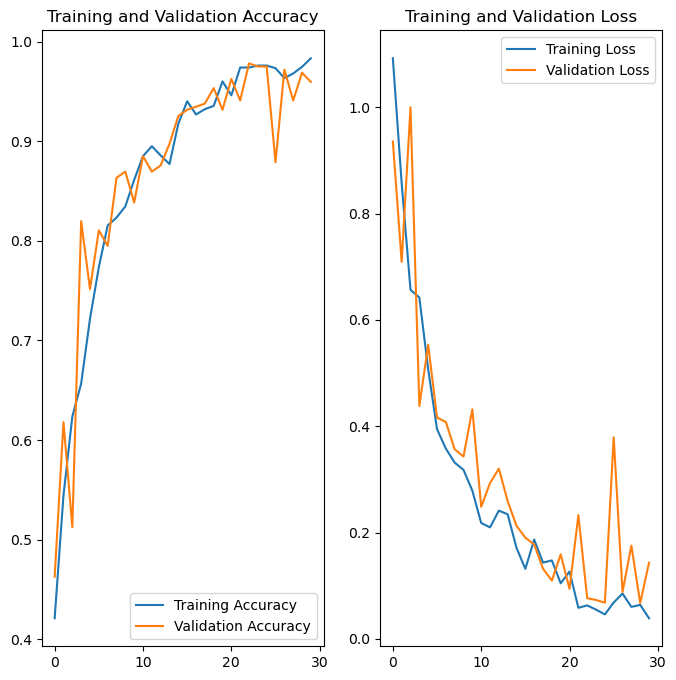

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write a function for inference

In [28]:
from tensorflow.keras.preprocessing import image as keras_image

def predict(model, class_names, img):
    # Preprocess the image
    target_size = (256, 256)  # Replace with your desired target size
    img = keras_image.array_to_img(img)
    resized_img = img.resize(target_size)
    resized_img_array = keras_image.img_to_array(resized_img)
    resized_img_array = np.expand_dims(resized_img_array, axis=0)  # Add batch dimension
    preprocessed_img = resized_img_array / 255.0  # Normalize pixel values
    
    # Make prediction
    predictions = model.predict(x=preprocessed_img,verbose=0)
    
    # Get predicted class and confidence
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

In [29]:
class_names = ['Potato Early blight', 'Potato Late_blight', 'Potato healthy']

##### Run prediction on a sample image

In [30]:
test_batch = test_generator.next()
test_images, test_labels = test_batch

In [31]:
predict(model, class_names=class_names, img=test_images[0])

('Potato Late_blight', 99.98)

**Now run inference on few sample images**

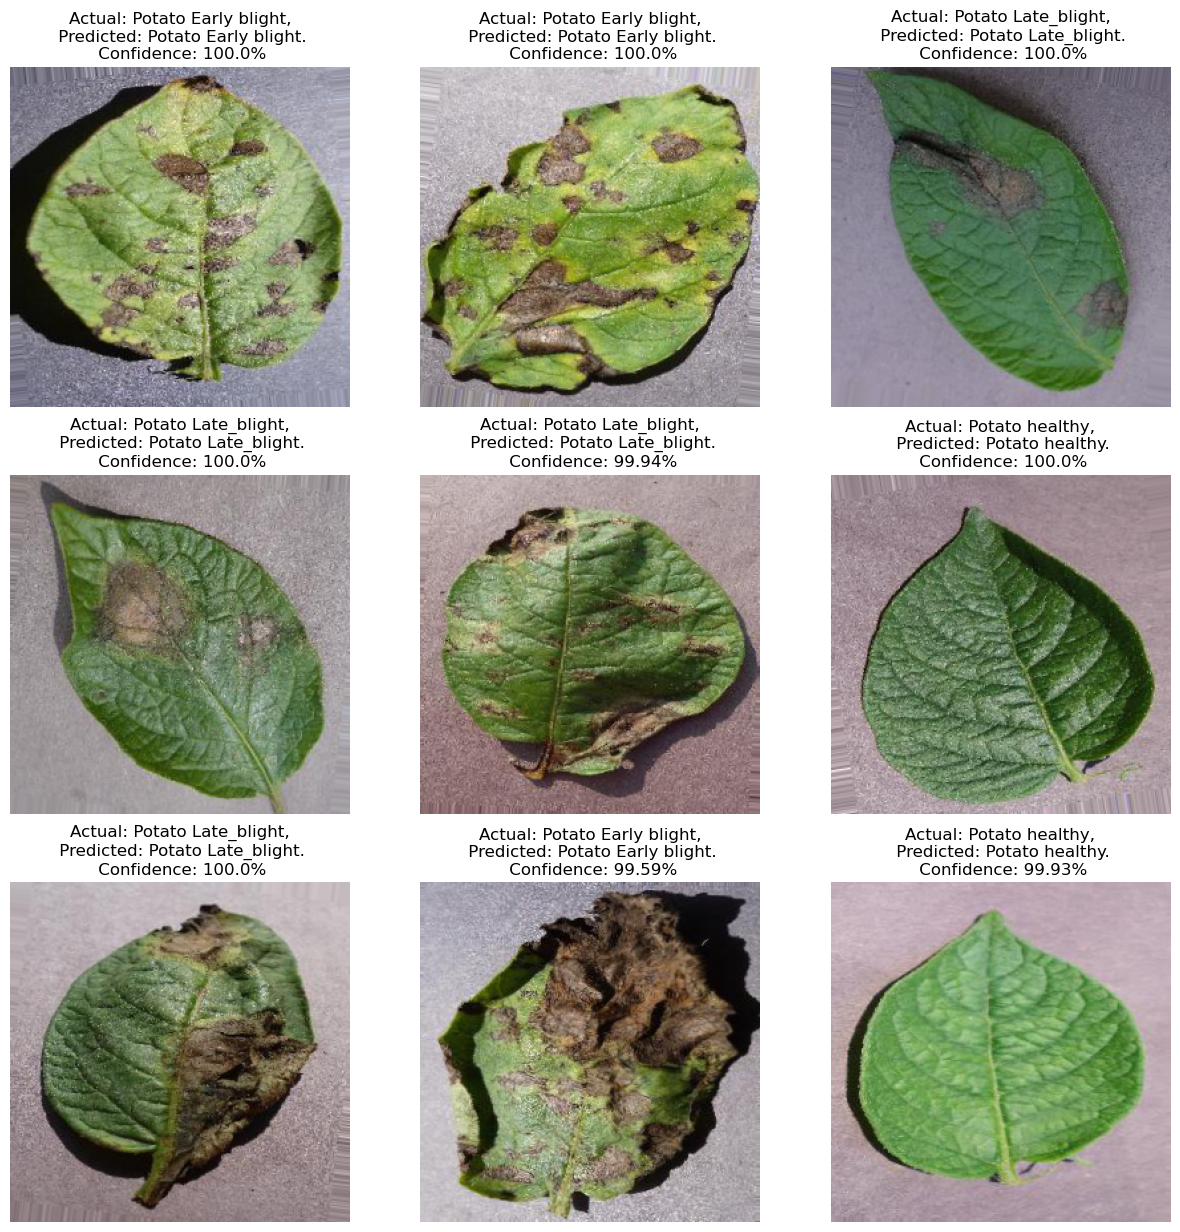

In [32]:
plt.figure(figsize=(15, 15))

# Number of images to display
num_images = 9
images_displayed = 0  # Counter to track displayed images

# Read and display images
for _ in range(num_images):
    test_batch = test_generator.next()
    for i in range(len(test_batch[0])):
        test_image = test_batch[0][i]  # Accessing the image
        
        ax = plt.subplot(3, 3, i + 1)   # 9 images displaying into 3*3 subplot
        plt.imshow(test_image)
        
        predicted_class, confidence = predict(model,class_names, test_image)
        actual_class = class_names[int(test_batch[1][i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')  # Remove axis from image
        
        images_displayed += 1
        if images_displayed >= num_images: # Conditions to break the loop
            break
    if images_displayed >= num_images:
        break

### Saving the Model and its INFO according to your versions

In [56]:
import os,json

model_folder = "saved_models/PotatoLeaf/FinalVersion"
model_name = "PotatoLeaf_model.h5"

In [58]:
#Saving model and its history in 
os.makedirs(model_folder,exist_ok=True)
model.save(os.path.join(model_folder,model_name))

history_dict=history.history
with open(os.path.join(model_folder, 'history.json'), 'w') as json_file:
    json.dump(history_dict, json_file)
    
with open(os.path.join(model_folder, 'classification_report.txt'), 'w') as file:
    file.write(report)

In [8]:
loaded_model = load_model(r"saved_models/PotatoLeaf/FinalVersion/PotatoLeaf_model.h5")

### on test data

In [32]:
# true_y = []
# pred_y = []

# # Iteratig over test_generator for true labels and predictions for the entire test set
# for i in range(len(test_generator)):
#     test_batch = test_generator.next()
    
#     true_classes = test_batch[1]
#     true_y.extend([class_names[int(label)] for label in true_classes])

#     batch_predictions = loaded_model.predict(test_batch[0],verbose=False)
#     pred_classes = [np.argmax(pred) for pred in batch_predictions]
#     pred_y.extend([class_names[pred] for pred in pred_classes])

    
# # Confusion Matrix and classification report
# cfm = confusion_matrix(true_y,pred_y)  
# print("Confusion Matrix:\n")
# print(cfm)
# print('-'*108)

# report = classification_report(true_y, pred_y, target_names=class_names)
# print("Classification Report:\n",report)

Confusion Matrix:

[[156   0   0]
 [  2 137   4]
 [  0   0  25]]
------------------------------------------------------------------------------------------------------------
Classification Report:
                      precision    recall  f1-score   support

Potato Early blight       0.99      1.00      0.99       156
 Potato Late_blight       1.00      0.96      0.98       143
     Potato healthy       0.86      1.00      0.93        25

           accuracy                           0.98       324
          macro avg       0.95      0.99      0.97       324
       weighted avg       0.98      0.98      0.98       324



### on train data

In [11]:
true_y = []
pred_y = []

# Iteratig over train_generator for true labels and predictions for the entire train set
for i in range(len(train_generator)):
    train_batch = train_generator.next()
    
    true_classes = train_batch[1]
    true_y.extend([class_names[int(label)] for label in true_classes])

    batch_predictions = loaded_model.predict(train_batch[0],verbose=False)
    pred_classes = [np.argmax(pred) for pred in batch_predictions]
    pred_y.extend([class_names[pred] for pred in pred_classes])

    
# Confusion Matrix and classification report
cfm = confusion_matrix(true_y,pred_y)  
print("Confusion Matrix:\n")
print(cfm)### on test data
print('-'*108)

report = classification_report(true_y, pred_y, target_names=class_names)
print("Classification Report:\n",report)

Confusion Matrix:

[[698   0   0]
 [  5 696   3]
 [  0   0 104]]
------------------------------------------------------------------------------------------------------------
Classification Report:
                      precision    recall  f1-score   support

Potato Early blight       0.99      1.00      1.00       698
 Potato Late_blight       1.00      0.99      0.99       704
     Potato healthy       0.97      1.00      0.99       104

           accuracy                           0.99      1506
          macro avg       0.99      1.00      0.99      1506
       weighted avg       0.99      0.99      0.99      1506



In [33]:
# for layer in loaded_model.layers:
#     if 'dropout' in layer.name.lower():  # Check if the layer is a Dropout layer
#         dropout_rate = layer.rate  # Get the dropout rate
#         print(f"Dropout Layer Name: {layer.name}, Dropout Rate: {dropout_rate}")

Dropout Layer Name: dropout, Dropout Rate: 0.3
